# Import Dependencies

In [1]:
import os
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt

import re
from nltk.corpus import stopwords
from textblob import TextBlob

%matplotlib inline

# Read into Python (Kaggle Dataset)

In [2]:
#load dataset
df = pd.read_csv('employee_reviews.csv')
df.head(5)

,Unnamed: 0,company,location,dates,job-title,summary,pros,cons,advice-to-mgmt,overall-ratings,work-balance-stars,culture-values-stars,carrer-opportunities-stars,comp-benefit-stars,senior-mangemnet-stars,helpful-count,link
0,1,google,none,"Dec 11, 2018",Current Employee - Anonymous Employee,Best Company to work for,People are smart and friendly,Bureaucracy is slowing things down,none,5.0,4.0,5.0,5.0,4.0,5.0,0,https://www.glassdoor.com/Reviews/Google-Revie...
1,2,google,"Mountain View, CA","Jun 21, 2013",Former Employee - Program Manager,"Moving at the speed of light, burn out is inev...","1) Food, food, food. 15+ cafes on main campus ...",1) Work/life balance. What balance? All those ...,1) Don't dismiss emotional intelligence and ad...,4.0,2.0,3.0,3.0,5.0,3.0,2094,https://www.glassdoor.com/Reviews/Google-Revie...
2,3,google,"New York, NY","May 10, 2014",Current Employee - Software Engineer III,Great balance between big-company security and...,"* If you're a software engineer, you're among ...","* It *is* becoming larger, and with it comes g...",Keep the focus on the user. Everything else wi...,5.0,5.0,4.0,5.0,5.0,4.0,949,https://www.glassdoor.com/Reviews/Google-Revie...
3,4,google,"Mountain View, CA","Feb 8, 2015",Current Employee - Anonymous Employee,The best place I've worked and also the most d...,You can't find a more well-regarded company th...,I live in SF so the commute can take between 1...,Keep on NOT micromanaging - that is a huge ben...,5.0,2.0,5.0,5.0,4.0,5.0,498,https://www.glassdoor.com/Reviews/Google-Revie...
4,5,google,"Los Angeles, CA","Jul 19, 2018",Former Employee - Software Engineer,"Unique, one of a kind dream job",Google is a world of its own. At every other c...,"If you don't work in MTV (HQ), you will be giv...",Promote managers into management for their man...,5.0,5.0,5.0,5.0,5.0,5.0,49,https://www.glassdoor.com/Reviews/Google-Revie...


# Data Inspection

In [3]:
df.shape

(67529, 17)

In [4]:
df.summary.isna().sum()

120

In [5]:
df['summary'].replace('', np.nan, inplace=True)
df.dropna(subset=['summary'], inplace=True)

In [6]:
df.shape

(67409, 17)

In [7]:
df.rename(columns={'overall-ratings':'rating', 'job-title':'title'}, inplace=True)

In [8]:
#removing unwanted columns
df.drop(['Unnamed: 0','link', 'pros','cons', 'advice-to-mgmt', 
        'work-balance-stars','culture-values-stars', 'carrer-opportunities-stars',
        'comp-benefit-stars', 'senior-mangemnet-stars','helpful-count',
        'dates', 'location', 'title', 'company'], axis=1, inplace=True)

In [9]:
df.head(3)

,summary,rating
0,Best Company to work for,5.0
1,"Moving at the speed of light, burn out is inev...",4.0
2,Great balance between big-company security and...,5.0


# Text Preprocessing

In [10]:
def preprocess(summary):
    summary = summary.str.replace("(<br/>)", "")
    summary = summary.str.replace('(<a).*(>).*(</a>)', '')
    summary = summary.str.replace('(&amp)', '')
    summary = summary.str.replace('(&gt)', '')
    summary = summary.str.replace('(&lt)', '')
    summary = summary.str.replace('(\xa0)', ' ')
    #removing punctuation
    summary = summary.str.replace('[^\w\s]','')
    summary = summary.str.replace('\d+', '')

    return summary

df['clean_text'] = preprocess(df['summary'])

In [11]:
df.head(4)

,summary,rating,clean_text
0,Best Company to work for,5.0,Best Company to work for
1,"Moving at the speed of light, burn out is inev...",4.0,Moving at the speed of light burn out is inevi...
2,Great balance between big-company security and...,5.0,Great balance between bigcompany security and ...
3,The best place I've worked and also the most d...,5.0,The best place Ive worked and also the most de...


In [13]:
%%time
#lowercasing
df['clean_text'] = df['clean_text'].str.lower()  

CPU times: user 30.1 ms, sys: 4.15 ms, total: 34.2 ms
Wall time: 34.4 ms


In [14]:
df.head(3)

,summary,rating,clean_text
0,Best Company to work for,5.0,best company to work for
1,"Moving at the speed of light, burn out is inev...",4.0,moving at the speed of light burn out is inevi...
2,Great balance between big-company security and...,5.0,great balance between bigcompany security and ...


# Language Detection

In [15]:
import langid

In [16]:
df.head(4)

,summary,rating,clean_text
0,Best Company to work for,5.0,best company to work for
1,"Moving at the speed of light, burn out is inev...",4.0,moving at the speed of light burn out is inevi...
2,Great balance between big-company security and...,5.0,great balance between bigcompany security and ...
3,The best place I've worked and also the most d...,5.0,the best place ive worked and also the most de...


In [17]:
# get the language id for each text
ids_langid = df['summary'].apply(langid.classify)

# get just the language label
langs = ids_langid.apply(lambda tuple: tuple[0])

# how many unique language labels were applied?
print("Number of tagged languages (estimated):")
print(len(langs.unique()))

# percent of the total dataset in English
print("Percent of data in English (estimated):")
print((sum(langs=="en")/len(langs))*100)

Number of tagged languages (estimated):
53
Percent of data in English (estimated):
86.0953285169636


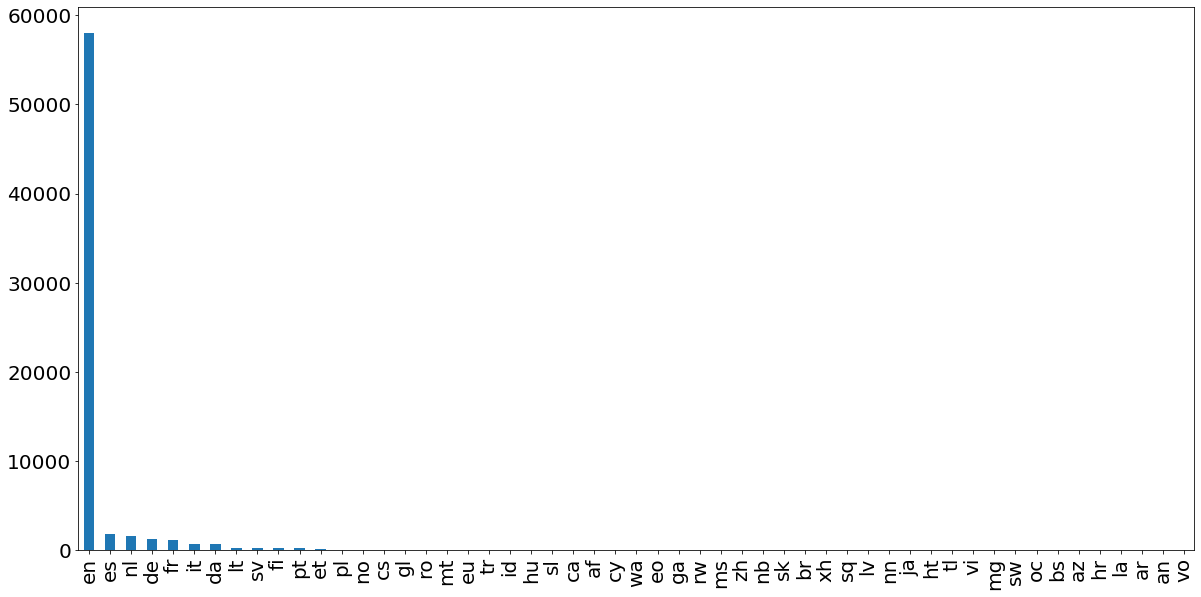

In [18]:
# convert our list of languages to a dataframe
langs_df = pd.DataFrame(langs)

# count the number of times we see each language
langs_count = langs_df.summary.value_counts()

# horrible-looking barplot (I would suggest using R for visualization)
langs_count.plot.bar(figsize=(20,10), fontsize=20)

In [19]:
print("Languages with more than 400 tweets in our dataset:")
print(langs_count[langs_count > 400])

print("")

print("Percent of our dataset in these languages:")
print((sum(langs_count[langs_count > 400])/len(langs)) * 100)

Languages with more than 400 tweets in our dataset:
en    58036
es     1829
nl     1587
de     1231
fr     1187
it      739
da      689
Name: summary, dtype: int64

Percent of our dataset in these languages:
96.86837069234079


In [20]:
# get just the language label
df['language'] = ids_langid.apply(lambda tuple: tuple[0])

In [21]:
df.head(3)

,summary,rating,clean_text,language
0,Best Company to work for,5.0,best company to work for,en
1,"Moving at the speed of light, burn out is inev...",4.0,moving at the speed of light burn out is inevi...,en
2,Great balance between big-company security and...,5.0,great balance between bigcompany security and ...,en


In [22]:
df.language.value_counts()

en    58036
es     1829
nl     1587
de     1231
fr     1187
it      739
da      689
lt      318
sv      271
fi      269
pt      251
et      119
pl      102
no       96
cs       89
gl       56
ro       56
mt       50
eu       48
tr       47
id       43
hu       42
sl       41
ca       38
af       27
cy       17
wa       10
eo        9
ga        9
rw        9
ms        8
zh        7
nb        7
sk        7
br        7
xh        6
sq        6
lv        6
nn        6
ja        5
ht        4
tl        4
vi        3
mg        3
sw        2
oc        2
bs        2
az        2
hr        2
la        2
ar        1
an        1
vo        1
Name: language, dtype: int64

In [23]:
df = df[df['language'] == 'en']

In [24]:
df.shape

(58036, 4)

# Spelling Correction

In [29]:
%%time
#spelling correction
df['clean_text'] = df['clean_text'].apply(lambda x: str(TextBlob(x).correct()))

CPU times: user 28min 44s, sys: 1.16 s, total: 28min 45s
Wall time: 28min 53s


In [32]:
df.head(4)

,summary,rating,clean_text,language
0,Best Company to work for,5.0,best company to work for,en
1,"Moving at the speed of light, burn out is inev...",4.0,moving at the speed of light burn out is inevi...,en
2,Great balance between big-company security and...,5.0,great balance between bigcompany security and ...,en
3,The best place I've worked and also the most d...,5.0,the best place give worked and also the most d...,en


# Export to CSV

Saving the clean data back to disk for future use

In [37]:
export_csv = df.to_csv (r'/Users/madhukumar/Downloads/cleaned.csv', index = None, header=True) 

In [38]:
export_csv

In [40]:
#Another way
df.to_csv("employee_reviews_clean.csv")
df.head()

,summary,rating,clean_text,language
0,Best Company to work for,5.0,best company to work for,en
1,"Moving at the speed of light, burn out is inev...",4.0,moving at the speed of light burn out is inevi...,en
2,Great balance between big-company security and...,5.0,great balance between bigcompany security and ...,en
3,The best place I've worked and also the most d...,5.0,the best place give worked and also the most d...,en
4,"Unique, one of a kind dream job",5.0,unique one of a kind dream job,en
